# Import Libraries
---

This is third code for House price prediction.<br/>
Please see before [LINK1](https://www.kaggle.com/code/ignorelee/gpu-based-house-price-eda-with-rapids).[LINK2](https://www.kaggle.com/code/ignorelee/dask-based-house-price-eda)<br/>
Now, we are porting that GPU-based code to [RAPIDS](https://rapids.ai/) on [Dask](https://docs.dask.org/en/stable/).<br/>
Our system environments include two NVIDIA GTX 2080 Supers, and the OS is Ubuntu 20.04 LTS.<br/>
I hope you feel the speed increase achieved by just using RAPDIS <br/>
If you see more RAPIDS code, See my github.

<a href="https://github.com/Ign0reLee/STUDY_RAPIDS">
<img  src="https://img.shields.io/badge/github-181717?style=flat-square&logo=github&logoColor=FFFFFF" />
</a>

<a href="https://github.com/Ign0reLee/STUDY_RAPIDS">
<img  src="https://img.shields.io/badge/DASK-FC6E6B?style=flat-square&logo=dask&logoColor=FFFFFF"/>
</a>

In [1]:
# For CPU Operations
import time
import logging
import subprocess
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

# For GPU array computation
import cupy as cp

# For GPU dataframe operation
import cudf

# Default DASK Libraries and set use GPU's
import dask
import dask_cudf
import dask.dataframe as dd
dask.config.set({"dataframe.backend": "cudf"})

# Set for Multi GPU use
from dask_cuda        import LocalCUDACluster
from dask.distributed import Client, wait, progress

# Dask Machine Learning Libraries
import dask_ml
from dask_ml.metrics         import mean_squared_error 
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV as GSCV

# For Train XGBoost
import xgboost as xgb

# For Visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import graphviz


# Ready to use Multi-GPU with DASK
---



In [2]:
cmd = "hostname --all-ip-addresses"
process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]

cluster = LocalCUDACluster(ip=IPADDR, silence_logs=logging.ERROR)
client = Client(cluster)

In [3]:
client

<Client: 'tcp://192.168.0.69:40363' processes=2 threads=2, memory=31.27 GiB>

# Make Timer

In [4]:
class Timer:
    def __init__(self, name="cpu"):
        self.name = name
        
    def __enter__(self):
        self.start = time.perf_counter()
        
    def __exit__(self, type, value, trackback):
        self.end = time.perf_counter()
        self.execute_time = self.end - self.start
        print(f"{self.name} execute time : {self.execute_time:.4f} seconds")

# Read Parquet Data

In [5]:
data_path = "./data/uk_housing.parquet"

In [6]:
with Timer("DASK"):
    gdf = dd.read_parquet(data_path, npartitions=40)
    

DASK execute time : 0.0330 seconds


we can use persist() for move our workflow into memory

In [7]:
with Timer("DASK"):
    gdf = gdf.persist()

DASK execute time : 0.0027 seconds


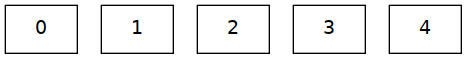

In [8]:
gdf.visualize()

# Make Label Encoder Function
---

Dask_cudf does not support string, and category types operation.<br/>
So we did not use dask_ml.preprocessing.LabelEncoder().[LINK](https://ml.dask.org/modules/generated/dask_ml.preprocessing.LabelEncoder.html#dask-ml-preprocessing-labelencoder)<br/>
There for we need to make label encoder for dask_cudf.<br/>
And that, we use map operation for multi-processing, but dask_cudf doesn't support Dask.DataFrame's, so we use it over Series.

In [9]:
def LabelEncoder(dd:dask.dataframe)->dask.dataframe:
    columns = dd.columns
    for c in columns:
        categories = dd[c].compute().unique()
        cat_dict   = {c : i for i, c in enumerate(categories.values_host)}
        dd[c] = dd[c].map(cat_dict)
    return dd

# Preprocessing with DASK
---

Finally, we run preproceeing with DASK.<br/>
Remeber, always use compute() operations is final step!


In [10]:
with Timer("DASK"):
    date_gpu = dd.to_datetime(gdf['Date of Transfer'])
    gdf['year']  = date_gpu.dt.year
    gdf['month'] = date_gpu.dt.month
    gdf['date']  = date_gpu.dt.day
    gdf = gdf[['Property Type', 'District', 'year', 'Price']]
    gdf[['Property Type', 'District']] = LabelEncoder(gdf[['Property Type', 'District']])
    train, test = gdf.random_split([0.8, 0.2])
    X_train, y_train = train[['Property Type', 'District', 'year']], train[['Price']]
    X_test,  y_test  = test[['Property Type', 'District', 'year']], test[['Price']]

DASK execute time : 2.8138 seconds


# Set paramters and run XGBoost
---

we run XGBoost on Multi-GPU to linear regression.<br/>
XGBoost library has dask method and we use that.<br/>
If you want more information see [LINK](https://xgboost.readthedocs.io/en/stable/tutorials/dask.html)

In [11]:
params = {
    'max_depth': 20,
    "verbosity": 2,
    'max_leaves':   2**8,
    'min_child_weight': 1,
    'objective':   "reg:squarederror",
    'grow_policy':  'lossguide',
    'eval_metric':  'rmse',
    'learning_rate': 0.01,
    'tree_method':"gpu_hist",
}

with Timer("DASK"):
    dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)
    model =  xgb.dask.train(client, params, dtrain, num_boost_round=100)

[19:05:17] task [xgboost.dask-0]:tcp://192.168.0.69:42423 got new rank 0
[19:05:17] task [xgboost.dask-1]:tcp://192.168.0.69:33485 got new rank 1


DASK execute time : 7.4419 seconds


# Result
---

so.. that's all! <br/>
It is easy to use. and Dask XGBoost return two object<br/>
One is 'booster'(our model) and other is hist(model history) we use 'booster' for analysis

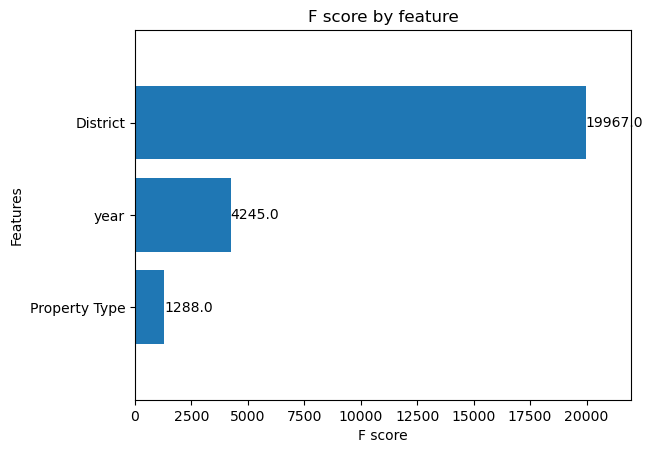

In [12]:
ax = xgb.plot_importance(model['booster'], height=.8)
ax.grid(False)
ax.set_title('F score by feature')
plt.show()

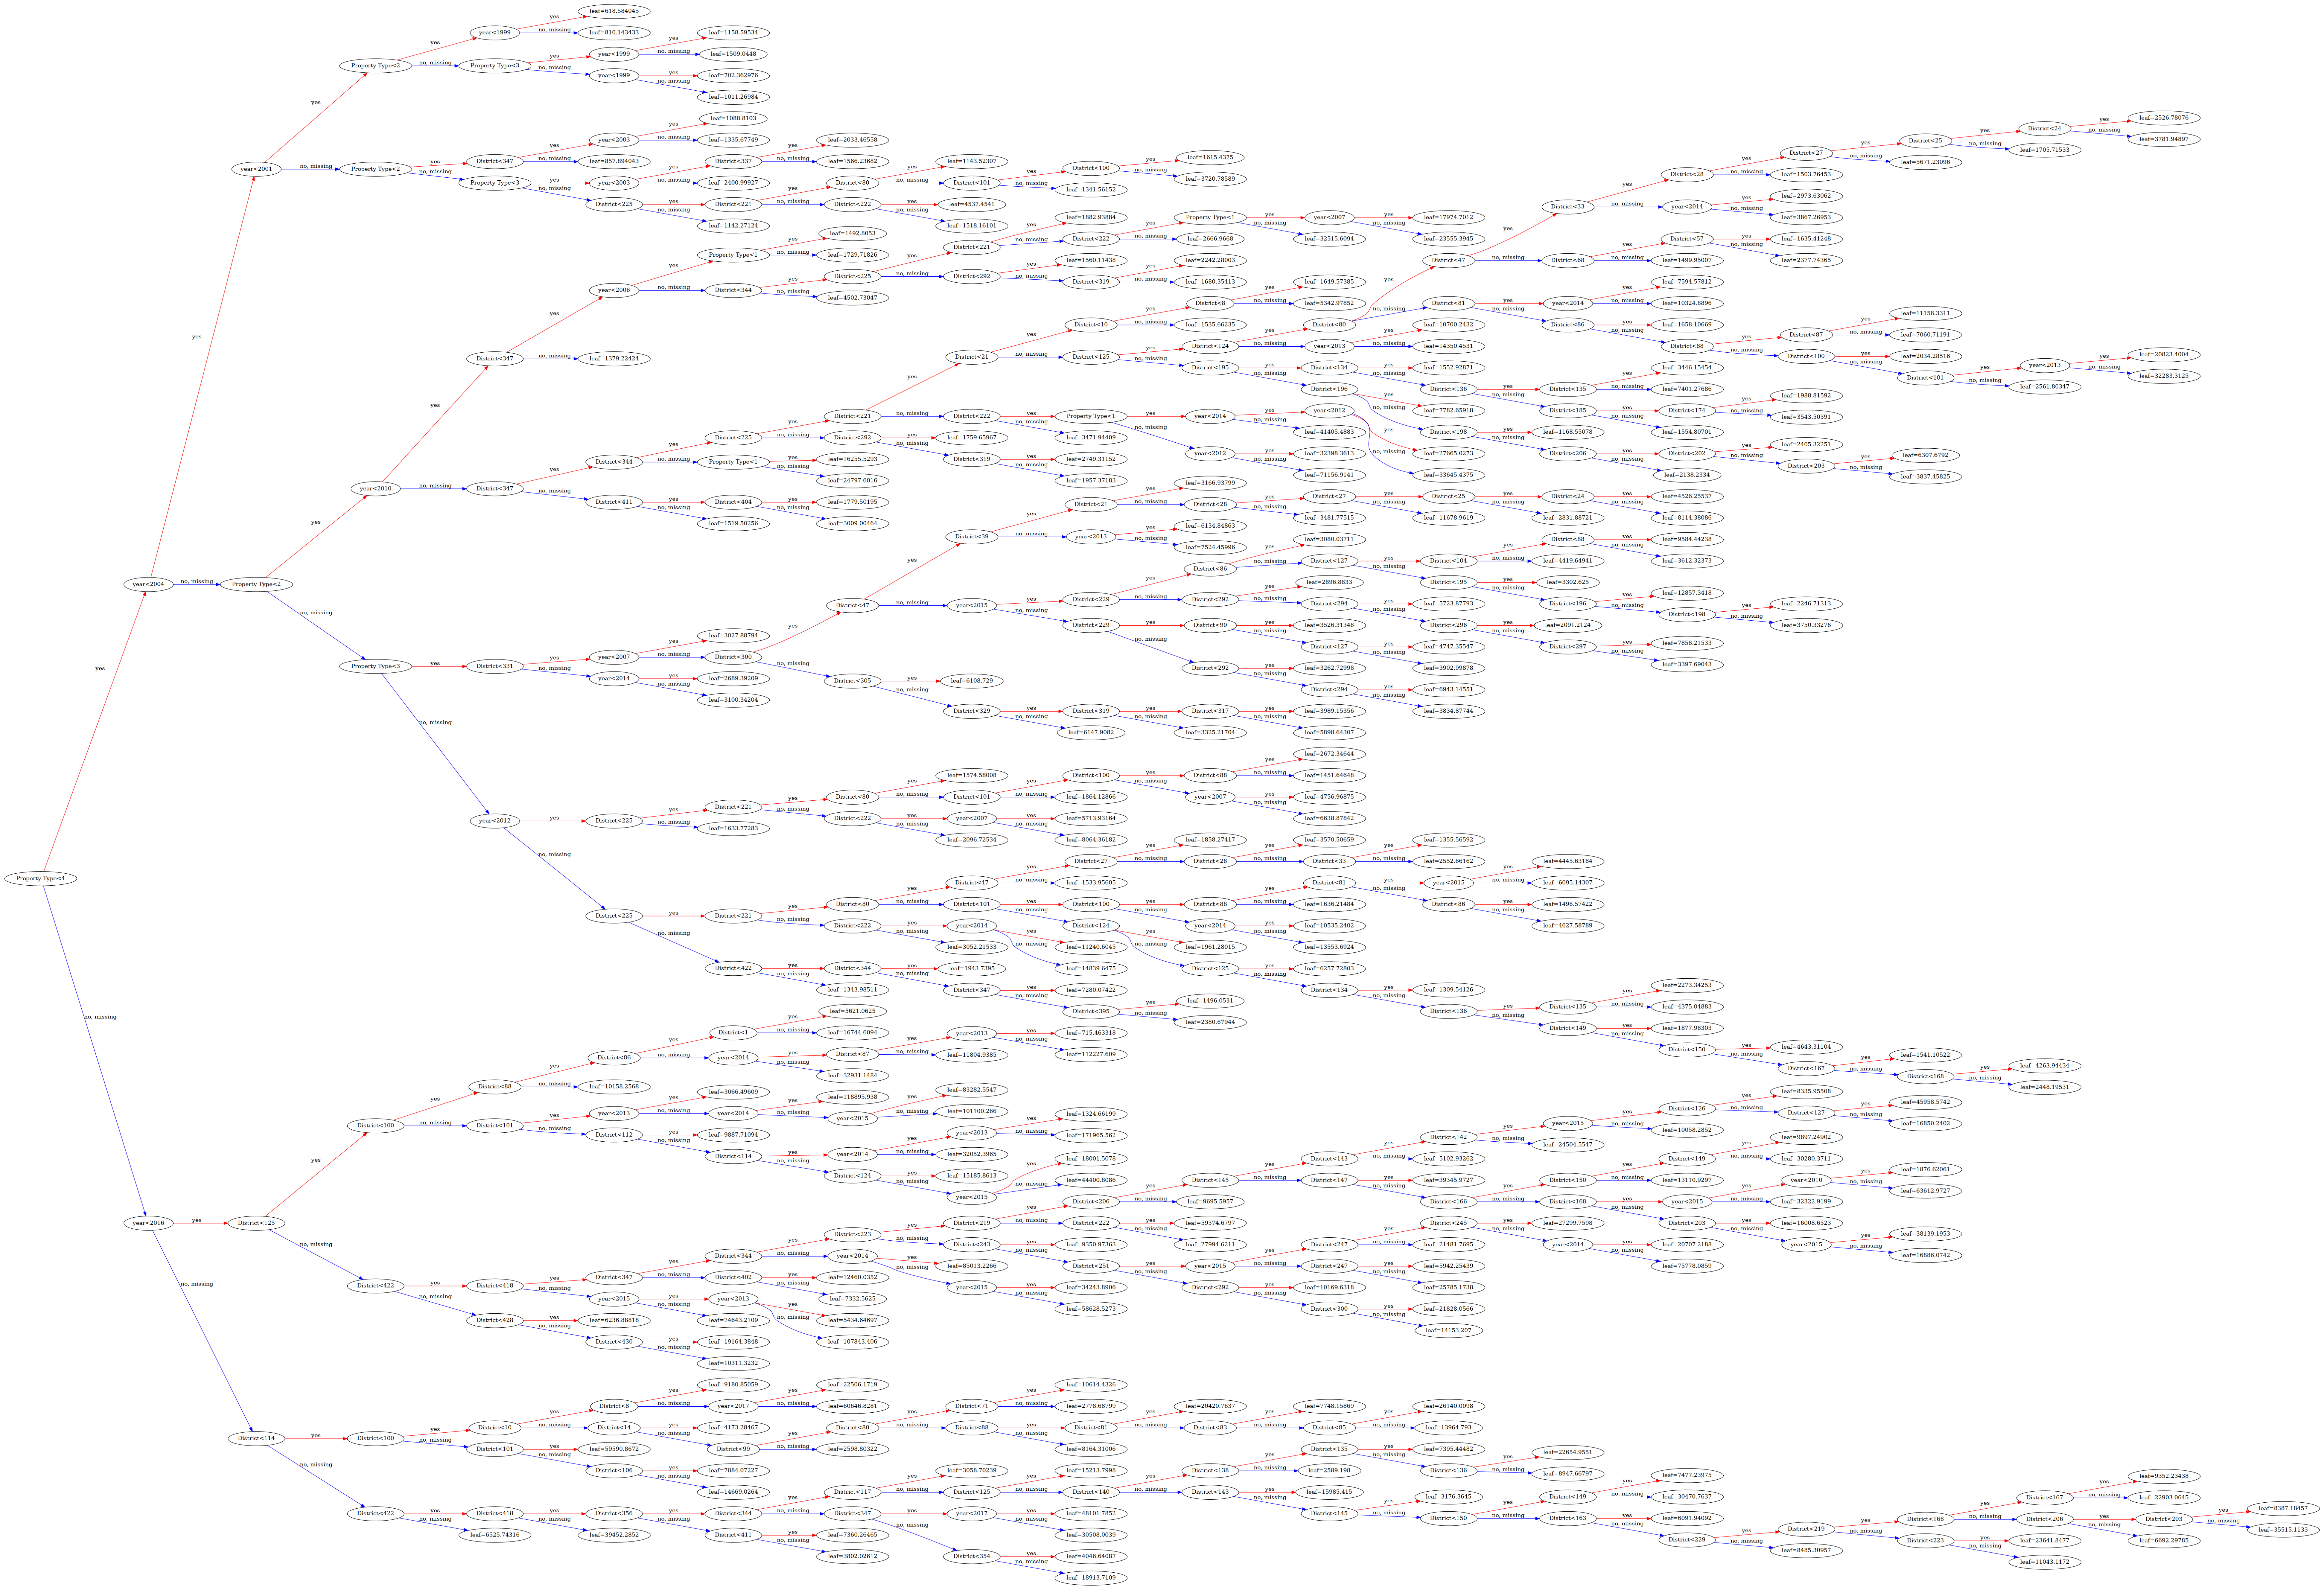

In [13]:
xgb.plot_tree(model['booster'], num_trees=0, rankdir='LR')

# get current figure to set the size
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(100, 100)

# Ablation Study
---

How was it?<br/>
Maybe UKHousing dataset's price is importance by district?<br/>
is it really good? let's check with test data!

In [14]:
with Timer("DASK"):
    dtest = xgb.dask.DaskDMatrix(client, X_test, y_test)
    prediction = xgb.dask.predict(client, model, dtest)

DASK execute time : 0.7792 seconds


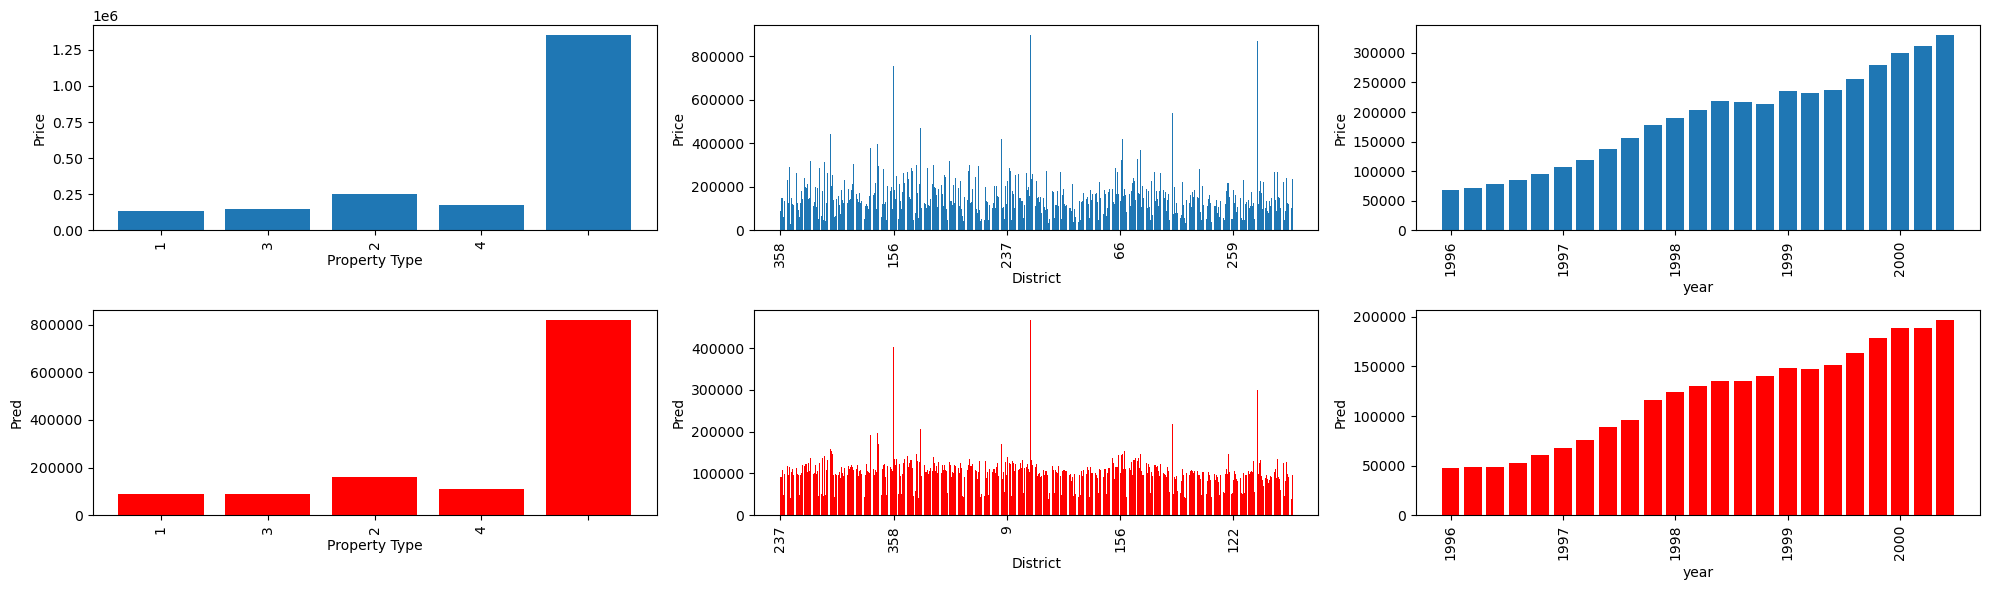

In [15]:
cat_cols = ['Property Type','District','year']
fig,axs = plt.subplots(nrows=2,ncols=3,figsize=(20,6))
test["Pred"] = prediction

for i, var in enumerate(cat_cols):
    prices = test[[var,"Price"]].groupby(var)["Price"].mean().compute().sort_values().to_pandas()
    axs[0,i].bar(prices.index, prices)
    axs[0,i].set_ylabel("Price")
    axs[0,i].set_xlabel(var)
    axs[0,i].set_xticklabels(prices.index, rotation=90)

    prices = test[[var,"Pred"]].groupby(var)["Pred"].mean().compute().sort_values().to_pandas()
    axs[1,i].bar(prices.index, prices, color="r")
    axs[1,i].set_ylabel("Pred")
    axs[1,i].set_xlabel(var)
    axs[1,i].set_xticklabels(prices.index, rotation=90)

fig.tight_layout()

plt.show()
plt.close()

In [16]:
print("Test MSE is : ",((test.Price - test.Pred) **2).mean().compute())

Test MSE is :  136959808347.92732


# Conclusion
---

The result of the figure shows a similar pattern.<br/>
But It's range too different. why? and how to improve performance??<br/>
See a next, Optimizing Hyper Parameter with grid search

## Acknowledgements
---

This work procced by modulabs's NVIDIA - Data Engineering with RAPIDS in Korea <br/>
Learn more : <br/>

<a href="https://modulabs.notion.site/NVIDIA-Data-Engineering-with-RAPIDS-LAB-136c69bcb0f34c458e7553b945dacad7?pvs=4">
<img  src="https://img.shields.io/badge/notion-000000?style=flat-square&logo=notion&logoColor=FFFFFF" />
</a>
<a href="https://modulabs.co.kr/">
<img  src="https://img.shields.io/badge/모두의-연구소-FE5196?style=flat-square" />
</a>
<a href="https://www.youtube.com/watch?v=1c3Zw31JhgQ">
<img  src="https://img.shields.io/badge/Youtube-FF0000?style=flat-square&logo=youtube&logoColor=FFFFFF" />
</a>